In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from datetime import date

In [2]:
clim = pd.read_csv('climate_2009_2016.csv', index_col = 0)

In [3]:
clim = clim.reset_index()
clim.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [4]:
df = clim[['Date Time','T (degC)']].rename(columns = {'T (degC)':'T','Date Time':'datetime'})
df.head()

,datetime,T
0,01.01.2009 00:10:00,-8.02
1,01.01.2009 00:20:00,-8.41
2,01.01.2009 00:30:00,-8.51
3,01.01.2009 00:40:00,-8.31
4,01.01.2009 00:50:00,-8.27


<Axes: >

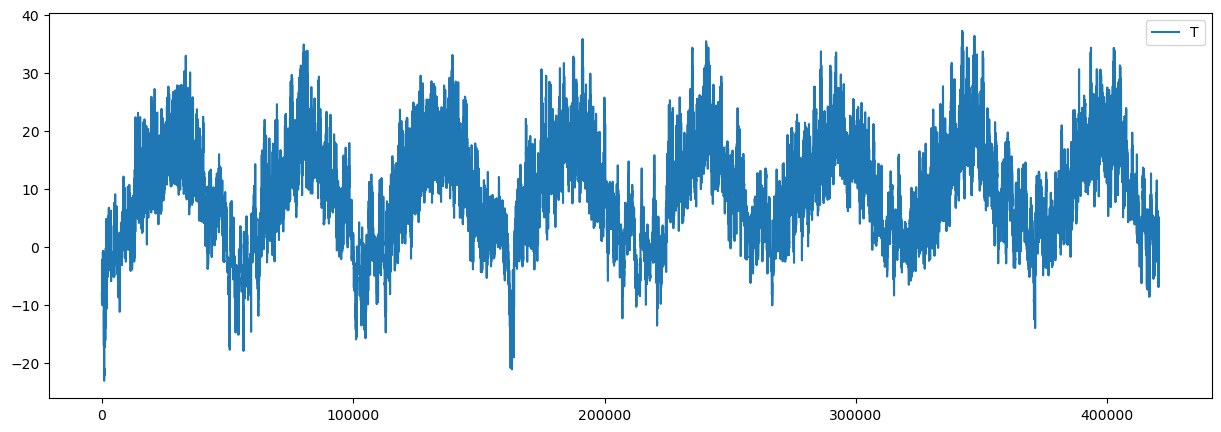

In [5]:
df.plot(figsize = (15,5))

In [6]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%d.%m.%Y %H:%M:%S')

In [7]:
type(df['datetime'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [8]:
df.head(10)

,datetime,T
0,2009-01-01 00:10:00,-8.02
1,2009-01-01 00:20:00,-8.41
2,2009-01-01 00:30:00,-8.51
3,2009-01-01 00:40:00,-8.31
4,2009-01-01 00:50:00,-8.27
5,2009-01-01 01:00:00,-8.05
6,2009-01-01 01:10:00,-7.62
7,2009-01-01 01:20:00,-7.62
8,2009-01-01 01:30:00,-7.91
9,2009-01-01 01:40:00,-8.43


In [9]:
# Taking each 6th record as we need hourly data, so we can ignore every other record (which are on 10 min level)

# We can also take mean/median of each consecutive 6 records if that is a business requirement, but right now it is not.

df_hour_lvl = df[5::6].reset_index().drop('index', axis=1)

In [10]:
df_hour_lvl.shape

(70091, 2)

In [11]:
df_hour_lvl.head()

,datetime,T
0,2009-01-01 01:00:00,-8.05
1,2009-01-01 02:00:00,-8.88
2,2009-01-01 03:00:00,-8.81
3,2009-01-01 04:00:00,-9.05
4,2009-01-01 05:00:00,-9.63


C:\Users\User\AppData\Local\Temp\ipykernel_6568\223933328.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_hour_lvl['T'])


<Axes: xlabel='T', ylabel='Density'>

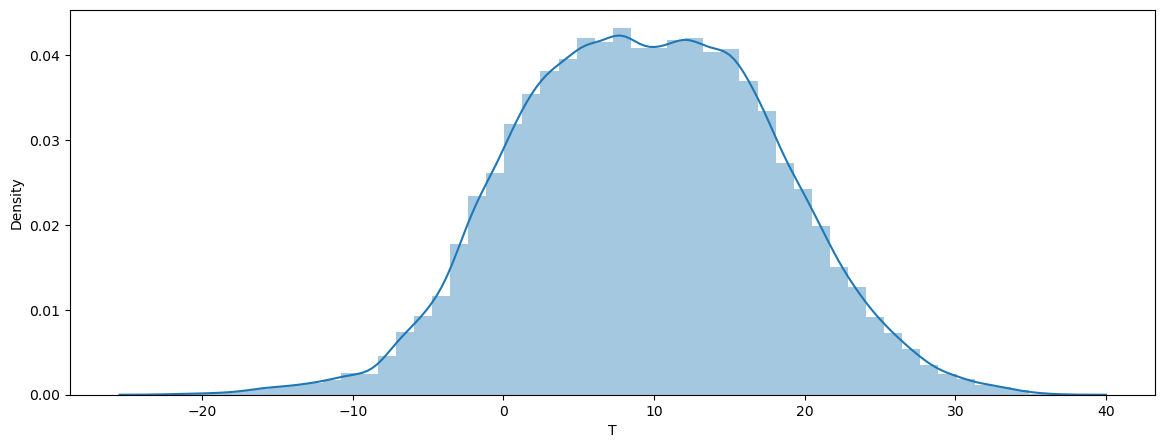

In [12]:
plt.figure(figsize = (14,5))
sns.distplot(df_hour_lvl['T'])

In [13]:
# we cannot simply provide a sequence of data points to an LSTM model for training and testing, 
# the input X sequence must be a 2D array [no of records, n_input], while the input y sequence must be a 1D array

def Sequential_Input_LSTM(df, input_sequence):
    df_np = df.to_numpy()
    X = []
    y = []
    
    for i in range(len(df_np) - input_sequence):
        row = [a for a in df_np[i:i + input_sequence]]
        X.append(row)
        label = df_np[i + input_sequence]
        y.append(label)
        
    return np.array(X), np.array(y)

In [14]:
n_input = 10      # number of historical inputs to be used for forecasting the future time series 

df_min_model_data = df_hour_lvl['T']

X, y = Sequential_Input_LSTM(df_min_model_data, n_input)

In [15]:
X.shape, y.shape

((70081, 10), (70081,))

In [16]:
# Training data
X_train, y_train = X[:60000], y[:60000]

# Validation data
X_val, y_val = X[60000:67000], y[60000:67000]

# Test data
X_test, y_test = X[67000:], y[67000:]

In [17]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(
#    X, y, test_size=0.2, random_state=42, stratify=y
#)

In [18]:
X_train.shape, y_train.shape

((60000, 10), (60000,))

In [19]:
X_val.shape, y_val.shape

((7000, 10), (7000,))

In [20]:
X_test.shape, y_test.shape

((3081, 10), (3081,))

In [21]:
# days

print('Temp :')
print()
print(f'Total days      : {len(df_hour_lvl)/24}')
print(f'Training days   : {len(X_train)/24}')
print(f'Validation days : {len(X_val)/24}')
print(f'Testing days    : {len(X_test)/24}')

Temp :

Total days      : 2920.4583333333335
Training days   : 2500.0
Validation days : 291.6666666666667
Testing days    : 128.375


In [22]:
#Creating the LSTM Model
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam 

In [23]:
n_features = 1                        # number of input variables used for forecast (here, only 1 i.e. temperature)

model1 = Sequential()

model1.add(InputLayer((n_input,n_features)))
model1.add(LSTM(100, return_sequences = True))     
model1.add(LSTM(100, return_sequences = True))
model1.add(LSTM(50))
model1.add(Dense(8, activation = 'relu'))
model1.add(Dense(1, activation = 'linear'))

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 100)             │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 10, 100)             │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │             408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 151,817 (593.04 KB)

 Trainable params: 151,817 (593.04 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)

model1.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate = 0.0001), metrics = [RootMeanSquaredError()])

In [25]:
model1.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 50, callbacks = [early_stop])

Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 222s 109ms/step - loss: 70.2449 - root_mean_squared_error: 8.2431 - val_loss: 8.8468 - val_root_mean_squared_error: 2.9744
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 235s 95ms/step - loss: 6.4609 - root_mean_squared_error: 2.5270 - val_loss: 1.4182 - val_root_mean_squared_error: 1.1909
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 195s 91ms/step - loss: 1.5768 - root_mean_squared_error: 1.2524 - val_loss: 0.7062 - val_root_mean_squared_error: 0.8404
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 169s 73ms/step - loss: 0.8570 - root_mean_squared_error: 0.9253 - val_loss: 0.5865 - val_root_mean_squared_error: 0.7658
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 146s 75ms/step - loss: 0.6959 - root_mean_squared_error: 0.8341 - val_loss: 0.6199 - val_root_mean_squared_error: 0.7874
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 171s 91ms/step - loss: 0.6537 - root_mean_squared_error: 0.8084 - val_loss: 0.5487 - val_root_mean_squared_error: 0.7407
Epoch 7/50
1875/1875

In [26]:
losses_df1 = pd.DataFrame(model1.history.history)
losses_df1

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error
0,40.106670,6.332983,8.846848,2.974365
1,4.461941,2.112331,1.418238,1.190898
2,1.287708,1.134772,0.706229,0.840374
3,0.798756,0.893731,0.586488,0.765825
4,0.680034,0.824642,0.619949,0.787368
5,0.649761,0.806078,0.548654,0.740712
6,0.635029,0.796887,0.575174,0.758403
7,0.625768,0.791055,0.563836,0.750890


<Axes: >

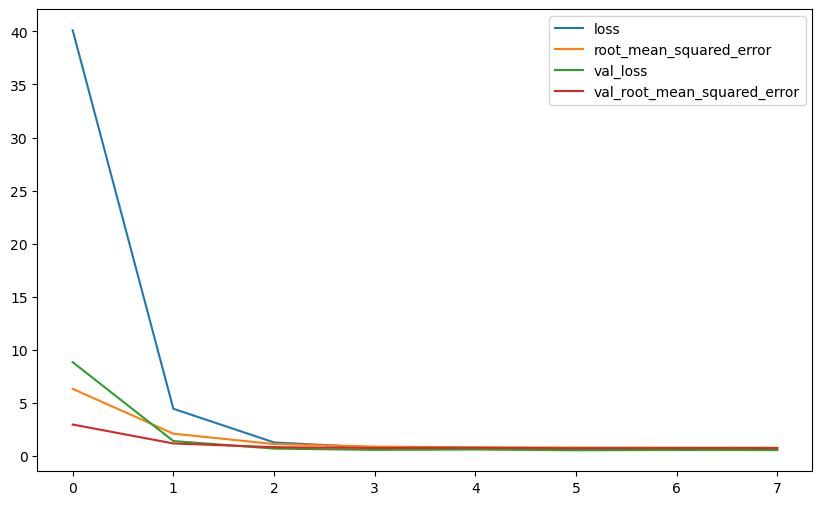

In [27]:
losses_df1.plot(figsize = (10,6))

In [28]:
scores = model1.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model1.metrics_names[0], scores[0]*100))
print("%s: %.2f%%" % ('RootMeanSquaredError', scores[1]*100))


loss: 47.52%
RootMeanSquaredError: 68.94%


In [29]:
test_predictions1 = model1.predict(X_test).flatten()
test_predictions1

97/97 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step


array([20.315052 , 21.238306 , 22.134878 , ..., -1.7077621, -2.982259 ,
       -2.8795521], dtype=float32)

In [30]:
len(X_test), len(test_predictions1)

(3081, 3081)

In [31]:
# check the dimension of the output (should be 1 for time series forecast)

test_predictions1.ndim

1

In [32]:
X_test_list = []
for i in range(len(X_test)):
    X_test_list.append(X_test[i][0])
    
len(X_test_list)

3081

In [33]:
test_predictions_df1 = pd.DataFrame({'X_test':list(X_test_list), 'LSTM Prediction':list(test_predictions1)})
len(test_predictions_df1)

3081

In [34]:
test_predictions_df1.head()

,X_test,LSTM Prediction
0,13.92,20.315052
1,14.15,21.238306
2,14.07,22.134878
3,14.46,22.605879
4,14.56,21.870365


<Axes: >

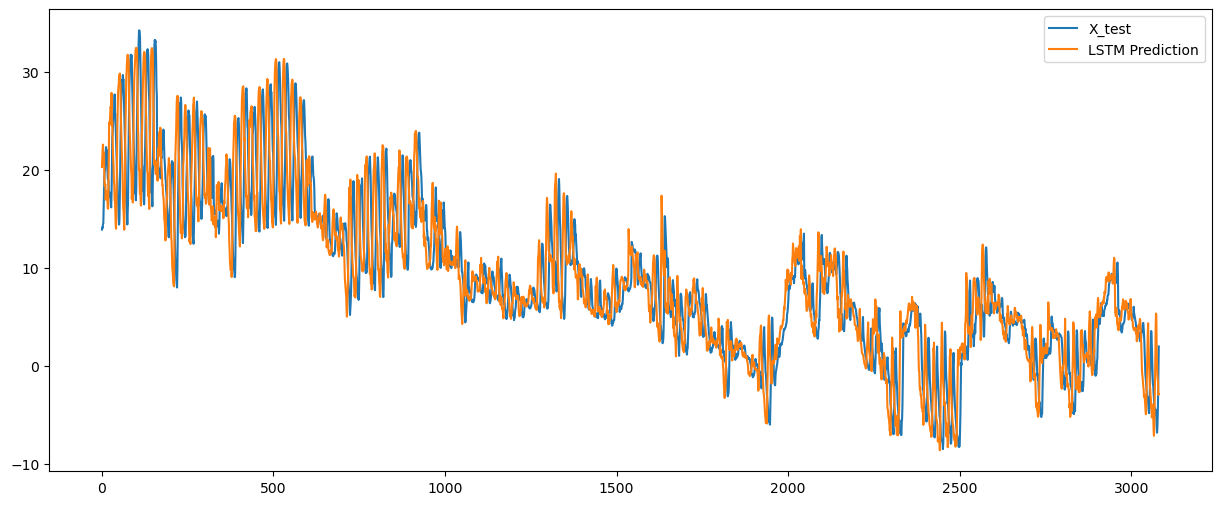

In [35]:
test_predictions_df1.plot(figsize = (15,6))

###### 